# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [197]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print data.dtypes
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicatessen        int64
dtype: object
Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [198]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [199]:
# TODO: Select three indices of your choice you wish to sample from the dataset
#print data[(data['Fresh'] > 20000) & (data['Frozen'] < 750)]
#print data[(data['Frozen'] > 4000)]
#print data[data['Fresh']>75000]
indices = [145,76,181]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)


Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,22039,8384,34792,42,12591,4430
1,717,3587,6532,7530,529,894
2,112151,29627,18148,16745,4948,8550


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**
An observation - all the distributions seem left skewed (mean 1.5-2 times larger than median)
- mean total spend across all categories is 33k m.u
- the first entry (subscript 0) is very high in fresh orders, and has almost no frozen orders. The overall spend of 75.7 is about 1-sigma larger than the mean. the sizeable fresh orders would suggest this is a moderately large cafe or deli that serves food made fresh.
- the second entry is 1-sigma higher than the mean on frozen, and below the 25%ile on fresh. the overall spend of 19.8 m.u is well below the mean. more frozen food and milk, some grocery, almost no fresh food, and smaller overall spend suggests this is a 'convenience' store (like an Aldi, 7-11 or Circle-K)
- the 3rd entry a large purchaser on aggregate (90k m.u. vs average of 33k m.u). it is the largest purchaser of fresh food in the dataset, but a large purchaser across the board. the aggregate size of purchases across categories suggests this might be a supermarket with a broad array of offerings.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [205]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split

features_list = ["Fresh","Milk","Grocery","Frozen","Detergents_Paper","Delicatessen"]

for feature in features_list:
    #target_vals = data['Detergents_Paper']
    target_vals = data[feature]
#    new_data = data
#    new_data = data.drop(['Detergents_Paper'],axis=1)
    print ("****")
    #print("Dropped Feature is: ", feature)
    new_data = data.drop([feature],axis=1)
    #display(new_data.describe())
    
# TODO: Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(
        new_data, data[feature], test_size=0.25, random_state=0)

# TODO: Create a decision tree regressor and fit it to the training set
    
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train,y_train)
    
    
    
# TODO: Report the score of the prediction using the testing set
#from sklearn.metrics import r2_score
#    y_predict = regressor.predict(X_test)
    score = regressor.score(X_test,y_test)

    print "r2 score for dropped feature ",feature," is - ",score
    print "feature importances - ",zip(new_data, regressor.feature_importances_)

****
r2 score for dropped feature  Fresh  is -  -0.252469807688
feature importances -  [('Milk', 0.17933073357941559), ('Grocery', 0.14508791388110318), ('Frozen', 0.45990587237272312), ('Detergents_Paper', 0.090729224074464015), ('Delicatessen', 0.12494625609229409)]
****
r2 score for dropped feature  Milk  is -  0.365725292736
feature importances -  [('Fresh', 0.14678611932194763), ('Grocery', 0.22779840166557785), ('Frozen', 0.011796603267152853), ('Detergents_Paper', 0.48140503222052405), ('Delicatessen', 0.13221384352479759)]
****
r2 score for dropped feature  Grocery  is -  0.602801978878
feature importances -  [('Fresh', 0.028130469062011415), ('Milk', 0.064525286318322786), ('Frozen', 0.024749564384700735), ('Detergents_Paper', 0.8698771771245366), ('Delicatessen', 0.012717503110428378)]
****
r2 score for dropped feature  Frozen  is -  0.253973446697
feature importances -  [('Fresh', 0.20588895254255626), ('Milk', 0.11687498560613246), ('Grocery', 0.067077916628263581), ('Deter

### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** 
- My intuition was that while restaurants may order different raw materials to cater to the tastes of their customers, the amount of detergent and paper was likely to be a function of the volume of customers (which in turn was a function of the total amount of food product ordered). 
- The high R2 score of 0.74 for Detergents_Paper supports my intuition that Detergents_Paper could be predicted from the combination of other food item related features.
- when Detergents_Paper is dropped, the feature importance of Grocery rises to 0.9 suggesting that it becomes the most important feature with Detergents_Paper dropped. The fact that Grocery elevates in importance and the overall r2-score with Detergents_paper dropped is high, suggests that Grocery captures most of the information value of Detergents_Paper and that D_P is a derived feature.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

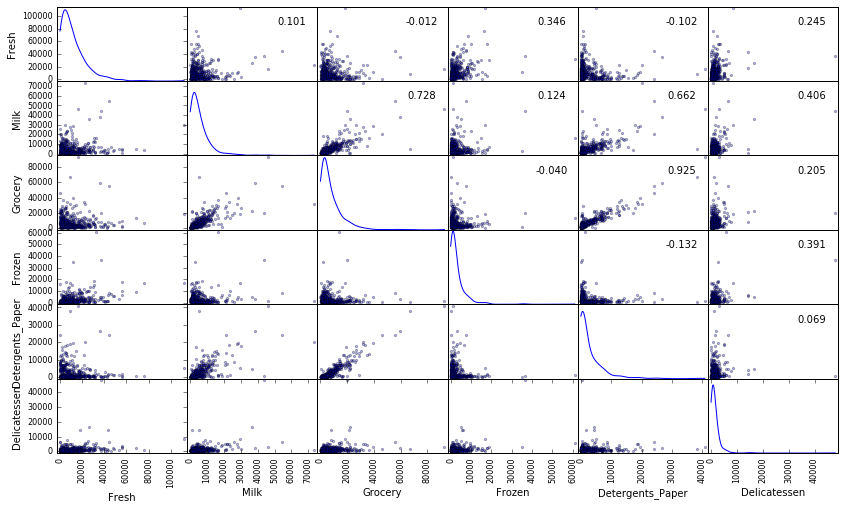

In [201]:
# Produce a scatter matrix for each pair of features in the data
axes=pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corr = data.corr().as_matrix()
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), 
                        xycoords='axes fraction', ha='center', va='center')

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:** 
- The triad of Milk, Grocery and Detergents_Paper seem to be fairly correlated. This can be seen by the fact that (Milk, Grocery), (Grocery, Detergents_Paper) and (Milk, Detergents_Paper) entries approximate diagonal lines, implying a fair amount of correlation. Of these the (Grocery, Detergents_Paper) correlation appears to be the strongest. 
- This confirms my hypothesis that Detergents_Paper was likely to be a function of more than one food product demand.

The data is not normally distributed. It is skewed strongly to the right (positive skew).

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

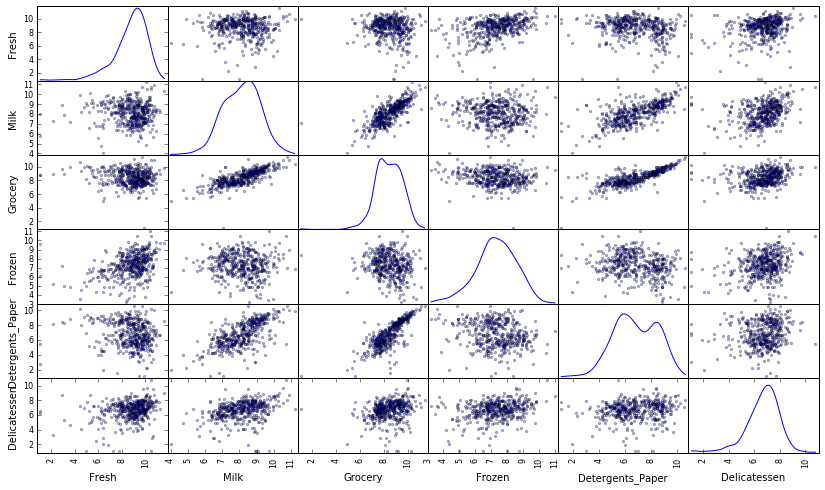

In [203]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
axes = pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [175]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
1,6.575076,8.185071,8.784468,8.926650,6.270988,6.795706
2,11.627601,10.296441,9.806316,9.725855,8.506739,9.053687


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


outliers for more than one feature,  [128, 154, 65, 66, 75]
removing the following outliers: [ 38  57  65  66  75  81  86  95  96  98 109 128 137 142 145 154 161 171
 175 183 184 187 193 203 218 233 264 285 289 304 305 325 338 343 353 355
 356 357 412 420 429 439]


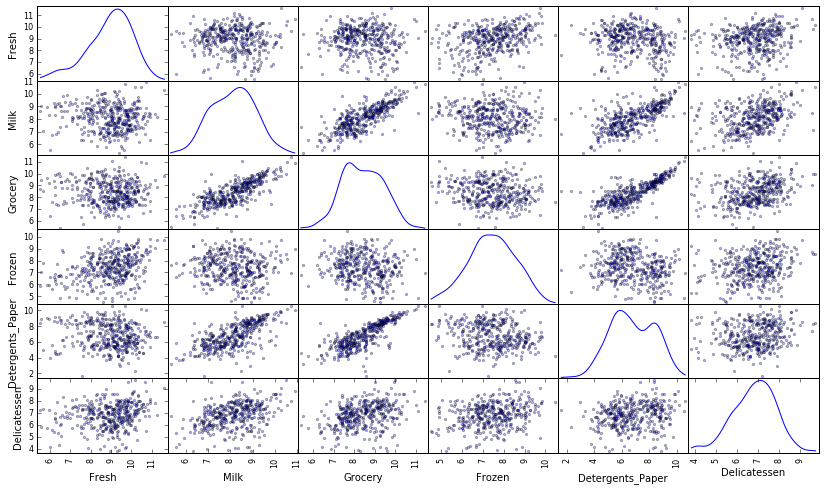

In [176]:
# For each feature find the data points with extreme high or low values

# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []

for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    outliers.extend(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index)
    #print "outliers --",outliers

#print "original outliers size, ", len(outliers)
    
from collections import Counter
duplicates = [item for item, count in Counter(outliers).iteritems() if count > 1]
print "outliers for more than one feature, ",duplicates

print "removing the following outliers:",np.unique(outliers)
outliers = np.unique(outliers)

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
#print "old and new sizes", len(data), len(log_data),len(outliers), len(good_data)

# Produce a scatter matrix for each pair of newly-transformed features on the good dataset
pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** There are 5 data points that are outliers for more than one feature - these are data points with indices 128, 154, 65, 66, and 75. Fourty three other points are outliers for a single feature. Removing all 48 points that were outliers on one or more features (almost) normalized the distributions on the scatterplots (redrawn above) and removed the skews from the earlier versions of the dataset.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

individual explained -  [ 0.49930484  0.22594807  0.10488309  0.09781761  0.04879109  0.0232553 ]
cumulative explained -  [ 0.49930484  0.7252529   0.83013599  0.92795361  0.9767447   1.        ]


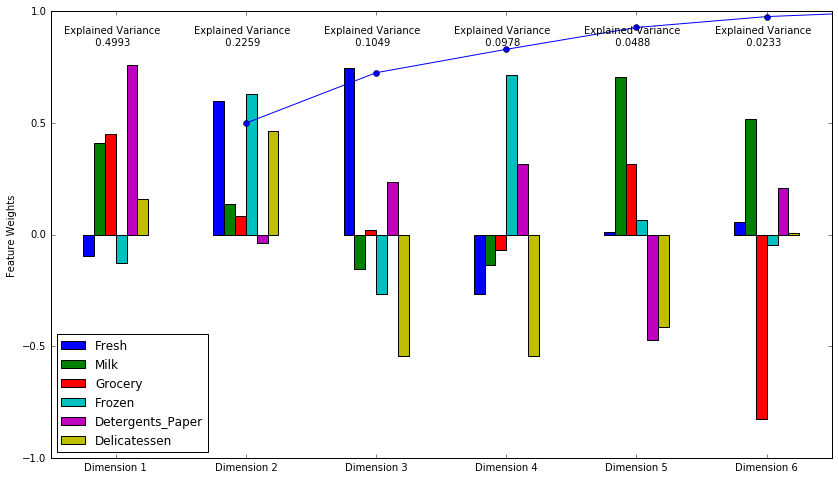

In [177]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6).fit(good_data)
print "individual explained - ",pca.explained_variance_ratio_
print "cumulative explained - ",np.cumsum(pca.explained_variance_ratio_)

# TODO: Transform the sample log-data using the PCA fit above
#pca_samples = None
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

import matplotlib.pyplot as plt
x = np.arange(1, 7)
plt.plot(x, np.cumsum(pca.explained_variance_ratio_), '-o')

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:** 
The individual and cumulative explained ratios for the first two components are : Individual - [ 0.49930484  0.22594807]. cumulative explained -  [ 0.49930484  0.7252529 ]. In other words, about 72.5% of the variance in data is explained by the first 2 principal components.
- The first principal component is correlated with Milk, Grocery and Detergents_Paper features of  customer spend, and Detergents_Paper is the most correlated. In a sense it represents spend on _consumer essentials_ 
- The second component is  positively correlated to Fresh, Frozen and Delicatessen in terms of spending. This represents consumer spending on _food_

The first 4 principal components explains about 92.7% of the variance in the data. So the 3rd and 4th principal components contribute an extra 20% to the explained variance. This is indicated by the Individual - [ 0.49930484  0.22594807  0.10488309  0.09781761], cumulative explained -  [ 0.49930484  0.7252529   0.83013599  0.92795361].
- The third dimension is highly positive correlated to Fresh, and the first component with a high -ve correlation to Delicatessen). Interestingly Delicatessen as a base feature is much more evenly distributed in principal components. This represents consumer spend on _healthy food_ that perishes quickly
- The fourth dimension is similar to the third where it has polar opposites in correlation in Frozen and Delicatessen. This represents customer spend on _frozen food_ that lasts a while and/or is fun (e.g. ice cream)


The fact that no principal component is completely lined up with any single base feature shows how PCA has 'skewed' (translated and rotated) almost all the base dimensions to some extent.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [178]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,3.9301,-0.7464,1.4396,-3.2188,-0.8550,-0.4139
1,-0.1635,-0.4167,-2.2779,1.5023,0.4812,-0.5754
2,2.6240,4.4608,0.2695,-0.1618,0.4241,0.3959


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [179]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [180]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,3.9301,-0.7464
1,-0.1635,-0.4167
2,2.6240,4.4608


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

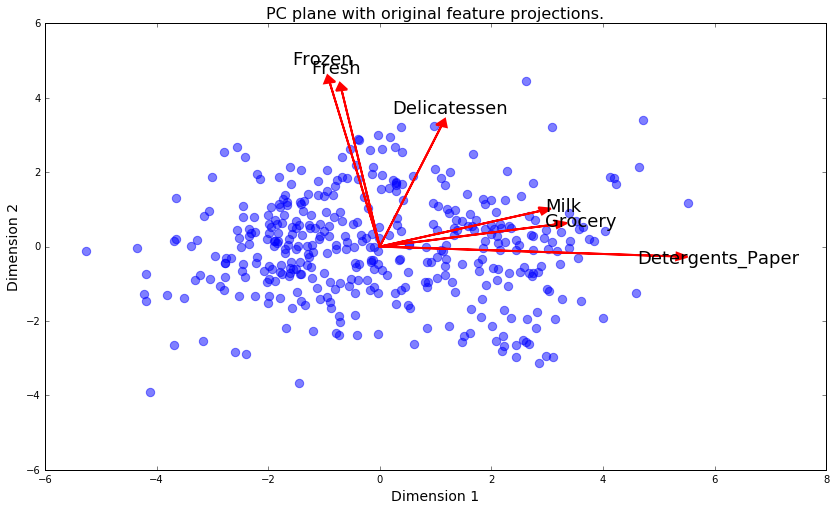

In [181]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

The biplot confirms the assertion in Q5 that Milk, Detergents_Paper and Grocery are highly correlated, and that Dimension 1 of the biplot picks up on those 3 original features and reduces those 3 features to a single feature. The plot in Q5 was much clearer than this biplot in showing that Detergents_Paper was the most strongly correlated with Dimension 1.

The biplot is also consistent with the results from the pca_results in Q5 that dimension 2 picks up and is positively correlated with Fresh, Frozen and Delicatessen.

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:** 

k-means clustering aims to partition observations into k clusters in which each observation belongs to the cluster with the nearest mean. K-means scales well with larger datasets, and is guranteed to converge. It does suffer from the curse of dimensionality (solved by pre-processing the content using PCA or other dimension reduction). And due to 'hard' assignments of points to clusters, small perturbations to initial starting points of the k-means candidates can lead to different clusters (because of some non-determinism in bucketing). k-means can also be sensitive to outliers that can 'pull' the cluster means significantly even as single data points.

gaussian mixture models are a soft form of clustering where data points can partially belong to multiple clusters. the extent to which a data point i belongs to a particular cluster j is proportional to probability that (gaussian) cluster j generated data point i. the probabilistic nature of gaussian mixture approaches makes it less susceptible to strange data 'shapes' and extreme outliers.

given that this data set has about 10% of the data points as outliers (48 out of 440), it might be advisable to use GMM over K-means.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

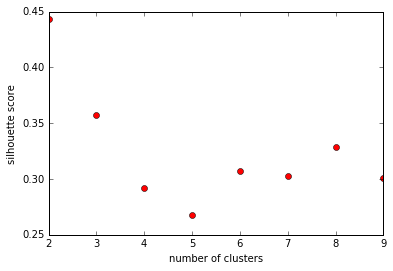

In [182]:
# TODO: Apply your clustering algorithm of choice to the reduced data
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_samples, silhouette_score
import pylab as pl

num_clusters = []
sil_scores = []

for num_components in range(2,10):
    #print "**** - ",num_components
#clusterer = None
    clusterer = GMM(n_components=num_components).fit(reduced_data)

# TODO: Predict the cluster for each data point
#preds = None
    preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
#centers = None
    centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
#sample_preds = None
    sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
#score = None
    score = silhouette_score(reduced_data,preds)
    num_clusters.append(num_components)
    sil_scores.append(score)
    #print ("silhouette score for {} components = {}").format(num_components,score)
    
pl.plot(num_clusters,sil_scores,'ro')
pl.xlabel('number of clusters')
pl.ylabel('silhouette score')
pl.show()

### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:** as can be seen in the plot above, the highest silhouette score of 0.444 is achieved with 2 clusters. increasing the cluster size beyong that generally (but not monotonically) decreases the cluster score.  

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

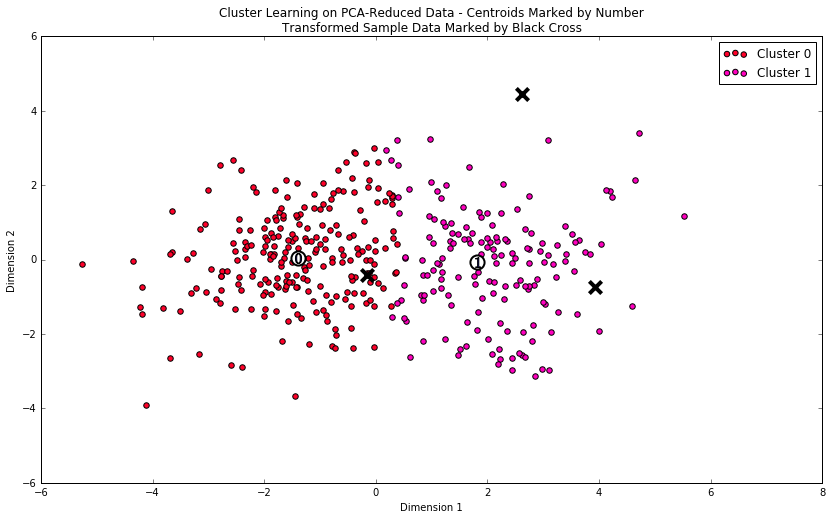

In [183]:
# Display the results of the clustering from implementation
clusterer = GMM(n_components=2).fit(reduced_data)
centers = clusterer.means_
preds = clusterer.predict(reduced_data)
sample_preds = clusterer.predict(pca_samples)
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8967.0,1920.0,2437.0,2081.0,309.0,741.0
Segment 1,6079.0,7042.0,10241.0,1275.0,3546.0,1159.0


Fresh               8504.0
Milk                3627.0
Grocery             4755.5
Frozen              1526.0
Detergents_Paper     816.5
Delicatessen         965.5
dtype: float64

Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicatessen         1524.870455
dtype: float64

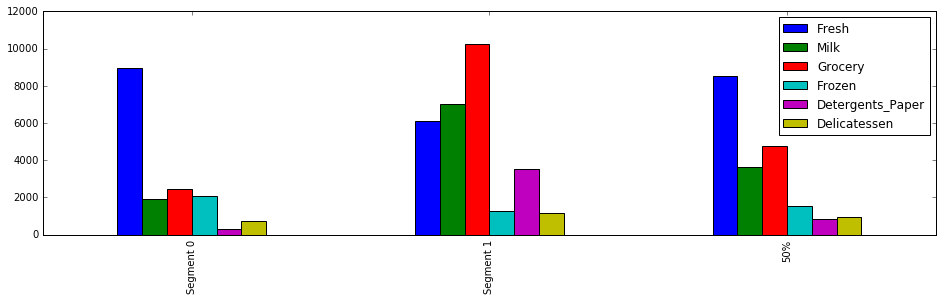

In [194]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)
#print "** medians **"
display(pd.DataFrame.median(data))
#print "** means **"
display(pd.DataFrame.mean(data))


true_centers = true_centers.append(data.describe().ix['50%'])
#true_centers = true_centers.append(data.describe().ix['mean'])
true_centers.plot(kind = 'bar', figsize = (16, 4))

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**
Since the distributions are left skewed, the population medians might be truer measures than population means in terms of characterizing the above segments. Cluster 0 orders more Milk, Grocery and Detergents_Paper than the median customer with the aggregate order (29K m.u) being between the median and the mean customer. The focus on fresh and consumer durables suggests a small supermarket with a focus on frequent shoppers. Cluster 1 is half the total size of Cluster 0 (about 16K m.u) and over 50% of its total order is Fresh. This suggests a grocery store with focus on perishables.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [195]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred
    
for i,j in enumerate(pca_samples):
    print "Probability of Sample {}: {}".format(i,clusterer.predict_proba([j])[0])

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1
Probability of Sample 0: [  2.93141500e-04   9.99706858e-01]
Probability of Sample 1: [ 0.7514816  0.2485184]
Probability of Sample 2: [ 0.00162177  0.99837823]


**Answer:** 
- Sample points 0 and 2 have larger than average orders of Milk and Grocery so it is consistent with the prediction of being in Cluster 0. 
- Sample point 1 has a large proportion of Fresh orders and therefore consitsten with the prediction of being in Cluster 1.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**
- we assume that customers within a cluster behave in a uniform way (i.e. the sample response is an accurate indicator of the cluster population response)
- we conduct the A/B test independently on each cluster
- within a cluster we assume that the satisfaction of the current customer is the null hypothesis (A) and that of a statistically significant sample (say 30 people from the cluster) is the 'change hypothesis' (B).
- after a period of time (domain knowledge) we conduct a user satisfaction survey (+/- 1 depending on whether sample user thinks new service an improvement) and apply a statistical significance test (e.g. t test) to determine lift from change hypothesis vs null hypothesis for any cluster
- we roll out the new service only for clusters where the change indicated a statistically significant improvement

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**
- Use a supervised learning algorithm with the 6 estimated product spending as features and customer segment as the target variable.
- Given that the cluster are quite cohesive, kNN would work well.
- once kNN has been trained, it can be used as a predictor for the 10 new customers based on their feature vector

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

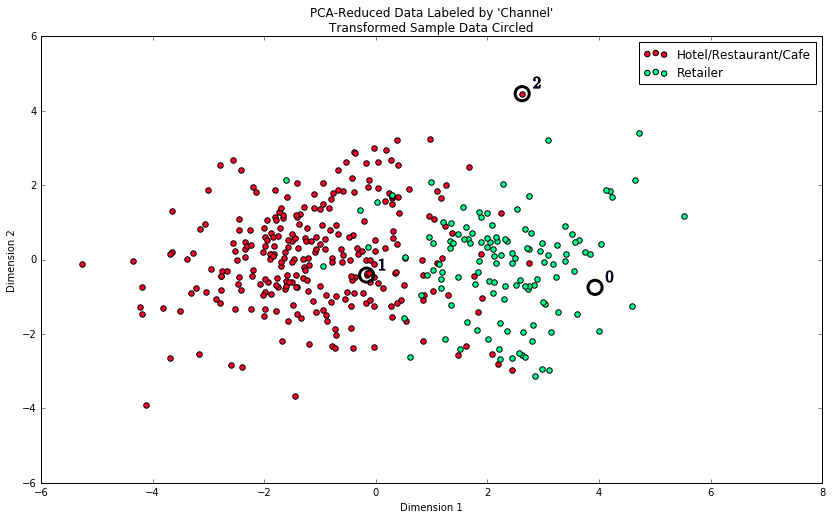

In [153]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**
- the clustering algorithm is quite consistent with the underlying distribution of Ho/Re/Ca and Retailer, modulo a misclassification of some of the outliers despite using GMM over K-means.
- cluster 0 captures most of the Ho/Re/Ca segment, and cluster 1 captures the retailers.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.